In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
cd /content/drive/

/content/drive


In [30]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [31]:
cd /content/drive/MyDrive/ASV/

/content/drive/MyDrive/ASV


In [32]:
import numpy as np
from gym import Env
from gym import spaces
import random
import matplotlib.pyplot as plt

# lbp = 7
xi = 0
yi = 0
xf = 150
yf = 150

v = 1
r = [0]
psi = [np.pi/4]

m = (yf-yi)/(xf-xi)
m_p = -1/m
theta = np.pi/2-np.arctan(m_p)



# LOS function

In [33]:
def LOS(xc,yc,psia):
    ini_a = np.array([xi,yi])
    fin_a = np.array([xf,yf])
    cur_pos = np.array([xc,yc])

    if xc != xi:
        m_c = (yc-yi)/(xc-xi)
    else:
        m_c = 40000          

    CTE = np.abs(np.linalg.norm(np.cross(fin_a-ini_a, ini_a-cur_pos)))/np.linalg.norm(fin_a-ini_a)
    
    x_inter = np.array([xc + CTE*np.cos(theta), yc + CTE*np.sin(theta)])
    delta = np.linalg.norm(x_inter - fin_a)
    alpha = np.pi/2 - np.arctan(m)
    if m_c < m:
        
        psi_d = alpha - np.arctan(CTE/delta)
    else:
        psi_d = alpha + np.arctan(CTE/delta)



    HE = psi_d-psia

    return HE, CTE

In [34]:
# xc = 10
# yc = 10
# he, cte = LOS(xc,yc,psi[-1])


# Dynamics

In [35]:
def dynamics(x,y,psi,r,delta):
    T = 107
    k = 4
    del_t = 1
    r_a = r[-1] + del_t*(k*delta-r[-1])/T
    psi_a = psi[-1] + r[-1]*del_t
    r = np.append(r,r_a)
    psi = np.append(psi,psi_a)
    x_a = x[-1] + v*np.sin(psi[-1])*del_t
    x = np.append(x,x_a)
    y_a = y[-1] + v*np.cos(psi[-1])*del_t
    y = np.append(y,y_a)
    return r,psi,x,y

# Calculating distance

In [36]:
def dist(x1,y1,x2,y2):
    ini_a = np.array([x1,y1])
    fin_a = np.array([x2,y2])
    return np.linalg.norm(ini_a - fin_a)

pathlen = dist(xi,yi,xf,yf)

# Reward

In [37]:
def Reward(HE,CTE, prev, curr):
    # Rew = 0
    # R1 = 0

    # if abs(CTE) <=2:
    #     R1 = 100
    # elif abs(CTE) <= 3.5 and abs(CTE) > 2:
    #     R1 = 20
    # else:
    #     R1 = -10

    # R2 = 30 - HE*180/np.pi

    # if curr <= prev:
    #     Rew = 5
    # else:
    #     Rew = -10

    # Rew = R1+R2


    # if HE <= np.pi/36 and CTE <=5:
    #     Rew = Rew*1.5

    # Rew = Rew/100
    
    Rew = 1 - (abs(HE)*abs(CTE))

    return Rew

# Environment

In [38]:
class CustomEnv(Env):

    metadata = {"render.modes": ["human"]}

    def __init__(self):
        super().__init__()
        
        self.r = r
        self.psi = psi
        [self.he , self.cte] = LOS(xi, yi,psi)
        self.x = [xi]
        self.y = [yi]
        self.done = False
        # Define action and observation space
        # They must be gym.spaces objects
        # Example when using discrete actions:
        self.action_space = spaces.Discrete(5)
        # Example for using image as input (channel-first; channel-last also works):
        self.observation_space = spaces.Box(low=np.array([-0.5, -np.pi, 0, -pathlen/2, min(xi,xf)-0.3*pathlen, min(yi,yf)-0.3*pathlen]), high=np.array([0.5, np.pi, np.pi, pathlen/2 , max(xi,xf)+0.3*pathlen, max(yi,yf)+0.3*pathlen]), shape = (6,), dtype=np.float32)

    def step(self, action):
        self.prev = dist(self.x[-1],self.y[-1],xf,yf)
        [ self.r, self.psi, self.x, self.y] = dynamics(self.x, self.y, self.psi, self.r, (np.pi/12)*(action - 2))
        self.curr = dist(self.x[-1],self.y[-1],xf,yf)
        [self.he , self.cte] = LOS(self.x[-1], self.y[-1], self.psi[-1])
        
        self.observation = np.array([self.r[-1], self.psi[-1], self.he , self.cte, self.x[-1], self.y[-1]], dtype = np.float32)

        self.reward = Reward(self.he, self.cte, self.prev, self.curr)

        self.steps += 1



        if self.steps >= 200:
            self.done = True
        if abs(self.cte) > pathlen/3:
            self.done = True
        if abs(np.abs(self.he)) > np.pi:
            self.done = True
        if self.x[-1] > 1.01*xf:
            self.done = True
        # if self.y[-1] > yf:
        #     self.done = True
        if self.curr < 2:
            self.done = True



        info = {}
        return self.observation, self.reward, self.done, info

    def reset(self):
        self.steps = 0
        self.r = [0]
        self.psi = [0]
        self.done = False
        [self.he , self.cte] = LOS(xi, yi,psi)
        self.x = [xi]
        self.y = [yi]
        self.info = {}

        observation = np.array([self.r[-1], self.psi[-1], self.he, self.cte, self.x[-1], self.y[-1]], dtype = np.float32)
        return observation, self.info  # reward, done, info can't be included

    def render(self, mode="human"):
        plt.plot([xi,xf],[yi,yf])
        plt.plot(self.x,self.y)
        plt.pause(0.1)
        plt.show()

    def close(self):
        ...

In [39]:
# pip install stable-baselines3

In [40]:
# from stable_baselines3.common.env_checker import check_env
env = CustomEnv()
# check_env(env)

/usr/local/lib/python3.8/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [41]:
# # import gym

# from stable_baselines3 import DQN

# model = DQN("MlpPolicy", env, verbose=1, learning_rate=0.001)
# model.learn(total_timesteps=100000, log_interval=4)
# model.save("dqn_cartpole")

# del model # remove to demonstrate saving and loading

# model = DQN.load("dqn_cartpole")
# done = False
# obs = env.reset()
# while not done:
#     action, _states = model.predict(obs, deterministic=True)
#     obs, reward, done, info = env.step(action)
#     env.render()
#     if done:
#       obs = env.reset()

In [42]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()


# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
# Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [44]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [45]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.999
EPS_END = 0.2
EPS_DECAY = 100
TAU = 0.005
LR = 1e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)



def select_action(state, epi):
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-epi / EPS_DECAY)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

<ipython-input-38-2f022eab8cea>:63: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  observation = np.array([self.r[-1], self.psi[-1], self.he, self.cte, self.x[-1], self.y[-1]], dtype = np.float32)


In [46]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    # return loss

<ipython-input-38-2f022eab8cea>:63: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  observation = np.array([self.r[-1], self.psi[-1], self.he, self.cte, self.x[-1], self.y[-1]], dtype = np.float32)


Streaming output truncated to the last 5000 lines.
cumalative reward =  -5.252931299336812
cumalative reward =  -12.44197789354737
cumalative reward =  -11.777714312416382
cumalative reward =  -17.714397525459997
cumalative reward =  -16.744860031761807
cumalative reward =  -20.70162559357269
cumalative reward =  -29.29342390320989
cumalative reward =  -32.00947512042795
cumalative reward =  -28.575797283195755
cumalative reward =  -24.282044544610248
cumalative reward =  -20.258645065375436
cumalative reward =  -16.157443095605593
cumalative reward =  -13.20783875050258
cumalative reward =  -11.622242818660347
cumalative reward =  -9.618288937730878
cumalative reward =  -7.452473017315604
cumalative reward =  -4.81021228272619
cumalative reward =  -0.9589774740692891
cumalative reward =  3.007044749341418
cumalative reward =  2.810289457693041
cumalative reward =  -0.3876883625164549
cumalative reward =  -0.4910088330865644
cumalative reward =  0.11496112473609521
cumalative reward = 

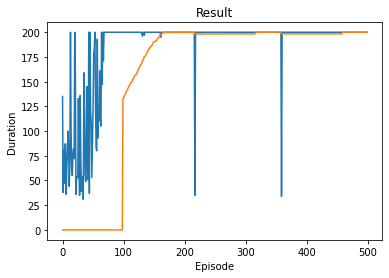

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [47]:
num_episodes = 500

state, info = env.reset()
state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
action = select_action(state,0)
observation, reward, done, info = env.step(action.item())

NoEpi             = []
Cumulative_reward = [] # cumulative reward
HEs               = [] # Average Heading error for an episode
# MSEs              = [] # Mean Square error for N episode
CTEs              = []
x_path = []
y_path = []
x = [observation[4]]
y = [observation[5]]
for i_episode in range(num_episodes):
    # Initialize the environment and get it's state

    total_reward = 0
    total_he     = 0 
    # total_mse    = 0
    total_cte    = 0
    NoEpi.append(i_episode)
    LoE = 1
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state, i_episode)
        # print(action)
        observation, reward, done, info = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        x.append(observation[4])
        y.append(observation[5])
        LoE += 1
        if done:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state
        # if i_episode%10 == 0:
        #     env.render()
        # Perform one step of the optimization (on the policy network)
        optimize_model()
        total_reward += reward.item()
        total_he     += np.rad2deg(observation[2])
        # total_mse    += float(loss)
        total_cte    += observation[3]
        if i_episode >= num_episodes - 10:
            x_path.append(observation[4])
            y_path.append(observation[5])
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if t%5 == 0:
            print("cumalative reward = ", total_reward)
        if done:
            episode_durations.append(t + 1)
            # plot_durations()
            break


    HEs.append(total_he/LoE) # theta is global declaration
    Cumulative_reward.append(total_reward/LoE)
    # MSEs.append(total_mse/LoE)
    CTEs.append(total_cte/LoE)

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [48]:
print(observation[4], observation[5])

137.36739 138.05748


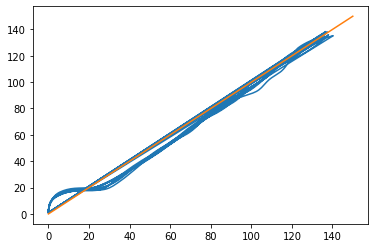

In [49]:
plt.plot(x_path,y_path)
plt.plot([xi,xf],[yi,yf])

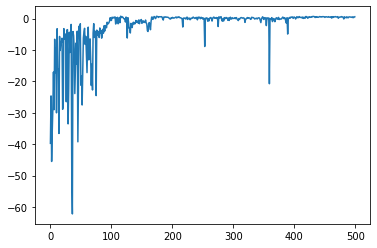

In [50]:
plt.plot(NoEpi, Cumulative_reward)

In [51]:
# plt.plot(NoEpi, MSEs)

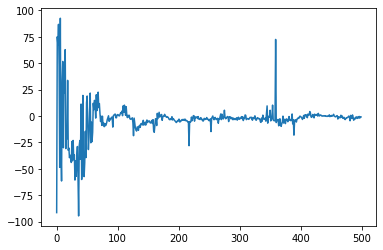

In [52]:
plt.plot(NoEpi, HEs)

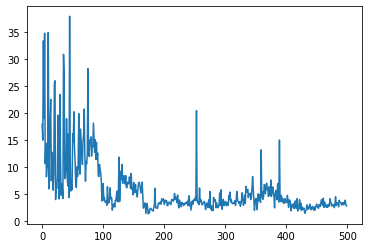

In [53]:
plt.plot(NoEpi, CTEs)

In [54]:
HEs

[-91.41911306100734,
 75.05456973344852,
 67.74836889127405,
 86.83653195699056,
 47.10613157532432,
 -48.582047366283156,
 92.62275396810996,
 -29.248671198263764,
 -61.47740923471843,
 33.3230786639275,
 51.7343704039792,
 -29.99529659483168,
 48.31540688915529,
 21.9114743334737,
 62.90552343708454,
 -30.81899702744406,
 -11.126421245081085,
 -21.629711982531425,
 33.81306255222803,
 -32.421252617178716,
 -30.191573414191677,
 -39.43761616374975,
 -36.983182350525986,
 -39.77961408116601,
 -43.956859827041626,
 -24.09012657183188,
 -42.392288091244986,
 -23.075762785087196,
 -40.964274022314285,
 -36.7773558980357,
 -60.59847881424595,
 -42.37204464077949,
 -57.039812391454525,
 -38.07490977883339,
 -28.83363015204668,
 -58.304664611816406,
 -94.54719617645792,
 -28.099581756351288,
 -23.13353931903839,
 -41.00257213396185,
 11.363146892149155,
 -60.082999733778145,
 -44.9529636823214,
 19.5561282699974,
 -41.10885057323858,
 -57.339697093216344,
 -44.24141415562786,
 -14.4650594342